In [1]:
import numpy as np
import tensorflow as tf
import networkx as nx
import collections
import matplotlib.pyplot as plt

#weights = np.loadtxt("weights_tract.txt") #structural
#length_matrix = np.loadtxt("lengths_tract.txt")
#connections = np.loadtxt("weights_surf.txt")
#averages = np.loadtxt("Experiment3/averages.txt")
weights = np.loadtxt("weights_tract.txt") #structural
length_matrix = np.loadtxt("lengths_tract.txt")
connections = np.loadtxt("weights_surf.txt")
averages = np.loadtxt("Experiment3/averages.txt")



In [2]:
from matricies import *

In [3]:
#all_rest = np.loadtxt("all_rest.txt", float, delimiter = ",")

In [4]:
#all_task = np.loadtxt("all_task.txt", float, delimiter = " ") #has rest and task. USE THIS
#all_rest.shape

In [5]:
#all_rest = np.reshape(all_rest, (66, 447, 2400))
#all_rest = np.swapaxes(all_rest, 0 , 1)
#plt.imshow(np.corrcoef(all_rest[0,:,:]))

#new_all_rest = all_rest[:, : , :1800]
#print(new_all_rest.shape)
#all_data = np.concatenate((all_task, new_all_rest), axis = 0)
all_data.shape

(894, 66, 1800)

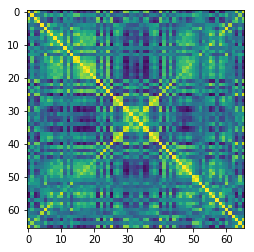

In [6]:
#all_task = np.reshape(all_task, (66, 447, 1800))
#all_task = np.swapaxes(all_task, 0 , 1)
plt.imshow(np.corrcoef(all_task[0,:,:]))

In [7]:
lengths = tf.constant(length_matrix, dtype = "float")

In [8]:
np.max(length_matrix)

length_mod = np.reshape([x if x != 0 else 250 for x in length_matrix.flatten() ], (66,66))



In [9]:
from random import randint 
def sample(all_scans):
    number = randint(0, np.shape(all_scans)[0] - 1) # change for new data set
    return all_scans[number], number

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0
Alpha:  0.001
Volumetric:  0.0011709604442344556
Surface:  -0.007368929271435839
386.08377


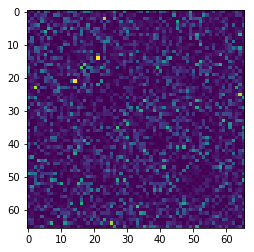

10000
Alpha:  0.001
Volumetric:  0.5373938502096102
Surface:  0.5565452628110906
0.3873983


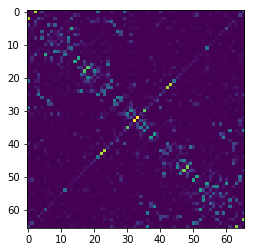

20000
Alpha:  0.001
Volumetric:  0.5343220698643677
Surface:  0.5564020486057916
0.4072345


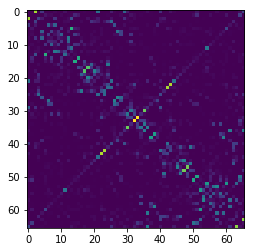

30000
Alpha:  0.001
Volumetric:  0.5368132126547756
Surface:  0.5617497414948469
0.40037763


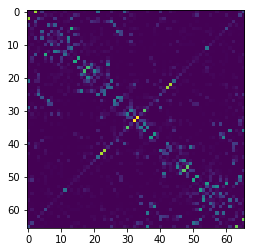

40000
Alpha:  0.001
Volumetric:  0.5328008581978271
Surface:  0.5557930603995548
0.4056105


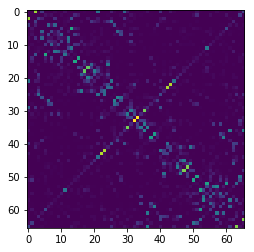

[[0.00000000e+00 0.00000000e+00 5.59216499e-01 ... 0.00000000e+00
  1.29749496e-02 1.23852305e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.84794452e-12
  1.16413936e-01 0.00000000e+00]
 [5.59216499e-01 0.00000000e+00 0.00000000e+00 ... 4.09141742e-03
  0.00000000e+00 3.25813191e-04]
 ...
 [0.00000000e+00 7.84794452e-12 4.09141742e-03 ... 0.00000000e+00
  6.91211084e-04 5.23188233e-01]
 [1.29749496e-02 1.16413936e-01 0.00000000e+00 ... 6.91211084e-04
  0.00000000e+00 2.25321054e-02]
 [1.23852305e-01 0.00000000e+00 3.25813191e-04 ... 5.23188233e-01
  2.25321054e-02 0.00000000e+00]]


In [10]:
import matplotlib.pyplot as plt
current_scan = all_data
num_timepts = current_scan.shape[2]
num_subjects = current_scan.shape[0]

alpha_corr = []
no_length = True
for j in range(1):
    rest = tf.placeholder(tf.float32, shape = (66, num_timepts - 1))
    dr = tf.placeholder(tf.float32, shape = (66, num_timepts - 1))
    dt = tf.constant(.72, dtype = tf.dtypes.float32)
    id = tf.constant(np.identity(66), dtype = tf.dtypes.float32)
    length_tru = tf.constant(length_mod, dtype = tf.dtypes.float32 )

    #alpha = tf.constant(0.050 * (j+1)) #without lengnths
    #alpha = tf.constant(0.0005 * (j+1)) # with lengths
    alpha = tf.constant(0.001 * (j+1))
    #0.0005 0.001 0.00015 0.002 0.0025 0.003
    #alpha gonna be higher without l enths (ex .1)

    weight_matrix0 = tf.Variable(np.random.randn(66,66), dtype = tf.dtypes.float32)
    weight_matrix1 = tf.add(weight_matrix0,tf.transpose(weight_matrix0))
    diagonal = tf.diag(tf.diag_part(weight_matrix1))
    weight_matrix2 = tf.subtract(weight_matrix1, diagonal)
    weight_matrix = tf.square(weight_matrix2)

    #(W-I)R
    weight_minus_id = tf.subtract(weight_matrix, id)
    predicted = tf.linalg.matmul(weight_minus_id, rest)
    predicted = tf.math.scalar_mul(dt, predicted)
    
    
    #loss = tf.losses.mean_squared_error(dr, predicted) + tf.math.multiply(tf.norm(weight_matrix), alpha)
    loss = tf.losses.mean_squared_error(dr, predicted) + tf.math.multiply(tf.norm(tf.multiply(weight_matrix, length_tru)), alpha)
    optimizer = tf.train.AdamOptimizer(learning_rate = .001).minimize(loss)
    #.004 too slow
    #.01 faster but only gets to 128 with 10000 iterations
    #.05 goes down to 600 then bounces back up
    #.1 bounces around too much
    #.025 bounces bck up too
    #.0009 gos down to 61
    #.00065 goes down to 70
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    for i in range(50000):
        random_sample, number = sample(current_scan)

        current_frame = np.delete(random_sample, num_timepts - 1, 1)
        next_step = np.delete(random_sample, 0, 1)
        change = np.subtract(current_frame, next_step)
        [opt, my_weights, session_loss, alph] = sess.run(fetches = [optimizer, weight_matrix, loss, alpha], feed_dict = {rest: current_frame, dr: change})
        if i%10000 == 0:
            print(i)
            print("Alpha: ", alph)
            print("Volumetric: ", np.corrcoef(weights.flatten(), my_weights.flatten())[0,1])
            print("Surface: ", np.corrcoef(connections.flatten(), my_weights.flatten())[0,1])
            
            print(session_loss)
            #correlate also with new file
            #correlate each for i in range(66) for each row and compare it to structural matrix
            #only look at quad 1 and quad 4 for the new file
            plt.imshow(my_weights)
            plt.show()
        if i == 50000 - 1:
            alpha_corr.append((np.corrcoef(weights.flatten(), my_weights.flatten())[0,1] , np.corrcoef(connections.flatten(), my_weights.flatten())[0,1]))
    print(my_weights)


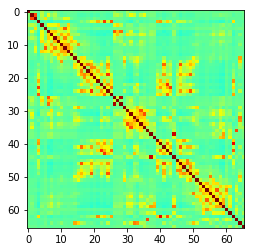

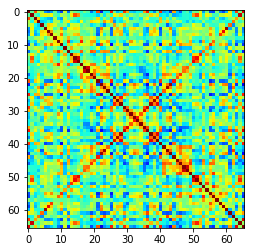

In [11]:
def show_m(matrix):
    plt.imshow(np.corrcoef(matrix), cmap = "jet")
    plt.clim(-1,1)
    plt.show()
show_m(weights)
show_m(all_rest[0])

In [12]:
np.arange(3) * 4

array([0, 4, 8])

In [13]:
averages = np.loadtxt("Experiment3/averages.txt")


[[1.         0.00551907]
 [0.00551907 1.        ]]


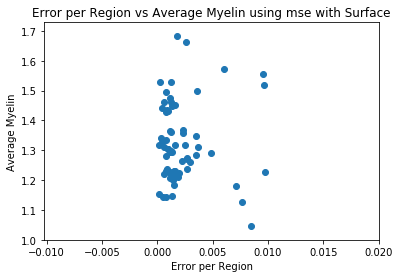

In [14]:
from rsq import myrsq
from numpy import linalg as LA
def generate_errors_and_correlation(matrix, rsq = False, diff = False):
    correlation = []
    errors = []
    #matrix = weights
    w,v = LA.eig(my_weights)
    my_weights_tf = my_weights/w[0]
    
    w,v = LA.eig(matrix)
    matrix = matrix/w[0]
    
    for i in range(66):
        if i < 33:
            #correlation.append(np.corrcoef(connections[i][33:].flatten(), my_weights[i][33:])[0,1])
            #mean_squared_error = (np.square(connections[i][33:] - my_weights[i][33:])).mean(axis = None)
            #errors.append(mean_squared_error)

            correlation.append(np.corrcoef(matrix[i][:33].flatten(), my_weights_tf[i][:33])[0,1])
            
            if rsq:
                errors.append(myrsq(matrix[i][:33], my_weights_tf[i][:33]))
            else: 
                if not diff:
                    mean_squared_error = (np.square(matrix[i][:33] - my_weights_tf[i][:33])).mean(axis = None)
                    errors.append(mean_squared_error)
                else:
                    mean_squared_error = (matrix[i][:33] - my_weights_tf[i][:33]).mean(axis = None)
                    errors.append(mean_squared_error)
        else:
            #correlation.append(np.corrcoef(connections[i][:33].flatten(), my_weights[i][:33])[0,1])
            #mean_squared_error = (np.square(connections[i][:33] - my_weights[i][:33])).mean(axis = None)
            #errors.append(mean_squared_error)

            correlation.append(np.corrcoef(matrix[i][33:].flatten(), my_weights_tf[i][33:])[0,1])
            
            if rsq:
                errors.append(myrsq(matrix[i][33:], my_weights_tf[i][33:]))
            else:
                if not diff:
                    mean_squared_error = (np.square(matrix[i][33:] - my_weights_tf[i][33:])).mean(axis = None)
                    errors.append(mean_squared_error)
                else: 
                    mean_squared_error = (matrix[i][33:] - my_weights_tf[i][33:]).mean(axis = None)
                    errors.append(mean_squared_error)
    return errors, correlation
error, correlations = generate_errors_and_correlation(weights, rsq = False, diff = False)
correlations = np.asarray(correlations)
error = np.asarray(error)
plt.scatter(error, averages)
plt.title("Error per Region vs Average Myelin using mse with Surface")
plt.xlabel("Error per Region")
plt.ylabel("Average Myelin")
print(np.corrcoef(error, averages))
plt.show()

In [15]:
my_weights

array([[0.00000000e+00, 0.00000000e+00, 5.59216499e-01, ...,
        0.00000000e+00, 1.29749496e-02, 1.23852305e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.84794452e-12, 1.16413936e-01, 0.00000000e+00],
       [5.59216499e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.09141742e-03, 0.00000000e+00, 3.25813191e-04],
       ...,
       [0.00000000e+00, 7.84794452e-12, 4.09141742e-03, ...,
        0.00000000e+00, 6.91211084e-04, 5.23188233e-01],
       [1.29749496e-02, 1.16413936e-01, 0.00000000e+00, ...,
        6.91211084e-04, 0.00000000e+00, 2.25321054e-02],
       [1.23852305e-01, 0.00000000e+00, 3.25813191e-04, ...,
        5.23188233e-01, 2.25321054e-02, 0.00000000e+00]], dtype=float32)

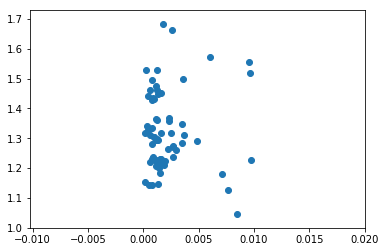

In [16]:
regions = {"ENT": "Entorhinal Cortex", "PARH": "Parahippocampal Cortex", "TP": "Temporal Pole", "FP": "Frontal Pole", 
           "FUS": "Fusiform Gyrus", "TT": "Transverse Temporal Cortex", "LOCC": "Laterial Occipital Cortex", 
           "SP": "Superior-Parietal Cortex", "IT":"Inferior Temporal Cortex", "IP": "Inferior-Pareietal Cortex",
           "SMAR": "Supramarginal Gyrus", "BTST": "Bank of the Superior Temporal Sulcus", "MT": "Middle Temporal Cortex",
           "ST": "Superior Temporal Cortex", "PSTC":"Postcentral Gyrus", "PREC": "Precentral Gyrus", "CMF": "Caudal Middle Frontal Cortex", 
           "POPE": "Pars Apercularis", "PTRI": "Par Triangularis", "RMF": "Roastral Middle Frontal Cortex", 
           "PORB": "Pars Orbitalis", "LOF": "Laterial Oribitofrontal Cortex", "CAC": "Caudal Anterior Cingulate Cortex", 
           "RAC": "Rostral Anterior Cingulate Cortex", "SF": "Superior Frontal Cortex", "MOF": "Medial Orbitofrontal Cortex", 
           "LING": "Lingual Gyrus", "PCAL": "Pericalcarine Cortex", "CUN": "Cuneus", "PARC": "Paracentral Lobule", "ISTC": "Isthmus of the Cinguate Cortex",
           "PCUM": "Precuneus", "PC": "Posterior Cingualate Cortex"}
values = list(regions.values())
keys = list(regions.keys())
plt.scatter(error, averages)


In [17]:
def get_cmap(n, name = 'hsv'):
    return plt.cm.get_cmap(name, n)

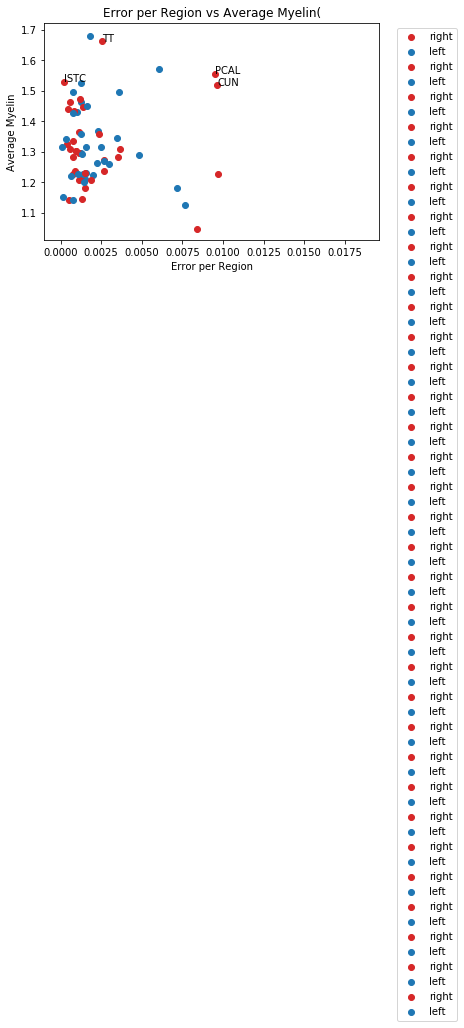

In [18]:
fig, ax = plt.subplots()
for i in range(33):
    ax.scatter(error[i], averages[i], c = "tab:red", label = 'right')
    ax.scatter(error[65 - i], averages[65 - i], c = "tab:blue", label = 'left')
    if error[i] > 1000 or averages[i] > 1.5:
        ax.annotate(keys[i], (error[i], averages[i]))
ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
plt.title("Error per Region vs Average Myelin" + "(")
plt.xlabel("Error per Region")
plt.ylabel("Average Myelin")
plt.show()

In [19]:
from tkinter import *
master = Tk()
variables = []    

def pr():
        fig, ax = plt.subplots()
        for i in range(33):
            rnd = np.random.random(3)
            if variables[i].get() == 1: 
                ax.scatter(aver_er[i], aver_wo[i], label = values[i] + "("+ keys[i] +")", c = rnd)
                ax.scatter(aver_er[65 - i], aver_wo[65 - i], c = rnd)
                #if aver_er[i] > 1000 or aver_wo[i] > 1.5:
                ax.annotate(keys[i], (aver_er[i], aver_wo[i]))
        ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
        master.destroy()
        
if False:
    for i in range(33):
        variables.append(IntVar())
        Checkbutton(master, text = values[i],
                    variable = variables[i]).grid(row = i, sticky = W)
    Button(master, text = "Show Plot", command = pr).grid(row = 0, column = 1, sticky = W)
    mainloop()

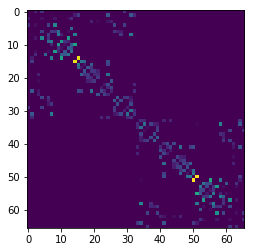

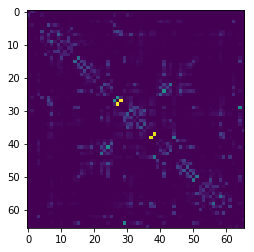

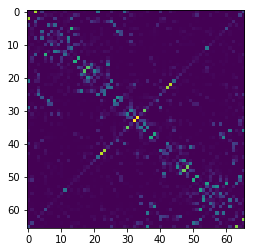

In [20]:
plt.imshow(connections)
plt.show()
plt.imshow(weights)
plt.show()
plt.imshow(my_weights)

In [21]:
aver_er = error
aver_wo = averages

In [22]:
#thirty_rest = np.loadtxt("30rest.txt", float, delimiter = ",")
#thirty_rest = np.reshape(thirty_rest, (66,30,1200)) #change for new data
#thirty_rest = np.swapaxes(thirty_rest, 0,1)
#plt.imshow(np.corrcoef(thirty_rest[0,:,:]))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

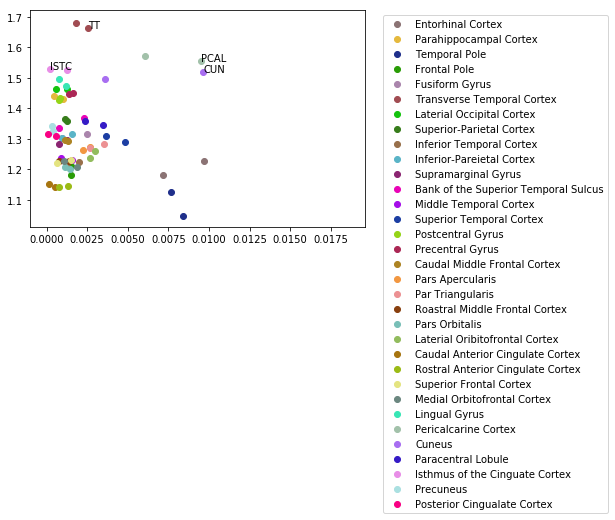

In [23]:
#cmap = get_cmap(33)
fig, ax = plt.subplots()
for i in range(33):
    rnd = np.random.random(3)
    ax.scatter(aver_er[i], aver_wo[i], label = values[i], c = rnd)
    ax.scatter(aver_er[65 - i], aver_wo[65 - i], c = rnd)
    if aver_er[i] > 1000 or aver_wo[i] > 1.5:
        ax.annotate(keys[i], (aver_er[i], aver_wo[i]))
ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
#TODO: 1) potentially spit the scatter into the two compositite lines and find 
# the line of fit the relates to each one. 2) Allow a check list which lets you 
# check the regions you want to be shown on the scatterplot

In [24]:
def get_top_left_quad(matrix):
    copy_matrix = np.copy(matrix)
    return_matrix = []
    
    
    

In [25]:
def top_percentage(matrix, percentage):
    return_matrix = matrix
    entries = return_matrix.flatten()
    sorted_entries = sorted(entries, reverse = True)
    number = int(len(sorted_entries) * (percentage/100)) 
    for i in range(len(sorted_entries)):
        if i >= number:
            sorted_entries[i] = 0
    for i in range(return_matrix.shape[0]):
        for j in range(return_matrix.shape[1]):
            current_element = return_matrix.item((i,j))
            return_matrix[i][j] = 1 if current_element in sorted_entries and current_element != 0 else 0
    print(return_matrix == my_weights)
    return return_matrix

[[ True  True False ...  True False False]
 [ True  True  True ... False False  True]
 [False  True  True ... False  True False]
 ...
 [ True False False ...  True False False]
 [False False  True ... False  True False]
 [False  True False ... False False  True]]
[[ True  True False ...  True False False]
 [ True  True  True ... False False  True]
 [False  True  True ... False  True False]
 ...
 [ True False False ...  True False False]
 [False False  True ... False  True False]
 [False  True False ... False False  True]]


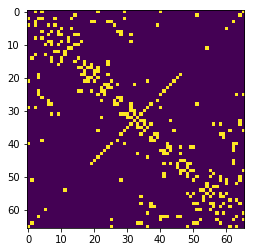

[[ True False False ...  True False False]
 [False  True  True ... False False  True]
 [False  True  True ... False  True False]
 ...
 [ True False False ...  True False False]
 [False False  True ... False  True False]
 [False  True False ... False False  True]]


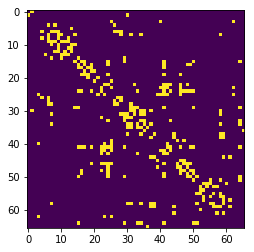

[[ True  True False ...  True False False]
 [ True  True  True ... False False  True]
 [False  True  True ... False  True False]
 ...
 [ True False False ...  True False False]
 [False False  True ... False  True False]
 [False  True False ... False False  True]]


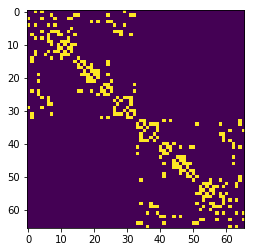

In [26]:
new_array = top_percentage(np.copy(my_weights), 7.5)
plt.imshow(new_array)
plt.imshow(top_percentage(np.copy(my_weights), 7.5))
plt.show()
plt.imshow(top_percentage(np.copy(weights), 7.5))
plt.show()
plt.imshow(top_percentage(np.copy(connections), 7.5))
plt.show()



In [27]:
degree_array = []
for i in range(66):
    degree_array.append(np.sum(new_array[i]))

In [28]:
degrees, counts = np.unique(degree_array, return_counts = True)
counts = np.divide(counts, 66)
together = zip(degrees, counts)
dictionary = dict()
for d,c in together:
    dictionary[d] = c
dictionary
degrees = [dictionary[deg] for deg in degree_array ]


In [29]:
def generate_degree_distribution(matricies, graph_name, labels, percentage = 15):
    return_tuple = []
    fig, ax = plt.subplots()
    i = 1
    
    
    for matrix, label in zip(matricies, labels):
        dictionary = dict()
    
            
        new_array = top_percentage(matrix, percentage)
        graph = nx.from_numpy_matrix(new_array)


        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
        print(degree_sequence)
        # print "Degree sequence", degree_sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())
        cnt = np.divide(cnt, matrix.shape[0])
        
        for d, c in zip(deg, cnt):
            dictionary[d] = c
        
        
        return_tuple.append((degree_sequence, dictionary))
        average_deg = np.sum([degree * count for degree, count in zip(deg,cnt)])
        #cnt = np.multiply(cnt, average_deg) 
        print("Average Degree for matrix ",str(i), ": ", average_deg)

    
    #plt.bar(deg, np.divide(cnt, 66), width=0.80, color='b')
        plt.scatter(deg, cnt, label = label)
        #plt.plot(deg, [np.mean(cnt)] * len(deg), label = "matrix" + str(i), linestyle = "--")
        plt.plot(deg,cnt,)
        i += 1

        plt.title("Distribution of Top " + str(percentage) + " Percent of Nodes for " + graph_name )
        plt.ylabel("Count")
        plt.xlabel("Degree")

       
        

    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")

    plt.show()
    return return_tuple

[[ True  True False ...  True False False]
 [ True  True  True ... False False  True]
 [False  True  True ... False  True False]
 ...
 [ True False False ...  True False False]
 [False False  True ... False  True False]
 [False  True False ... False False  True]]
[17, 15, 14, 14, 14, 14, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 4]
Average Degree for matrix  1 :  9.909090909090908
[[ True False False ...  True False False]
 [False  True  True ... False False  True]
 [False  True  True ... False  True False]
 ...
 [ True False False ...  True False False]
 [False False  True ... False  True False]
 [False  True False ... False False  True]]
[24, 23, 22, 20, 20, 17, 16, 16, 15, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 9, 9, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6,

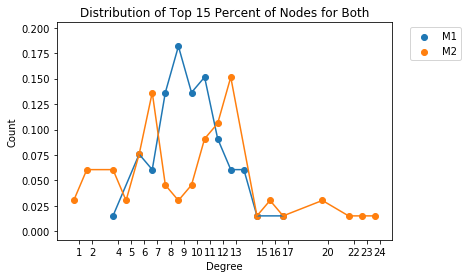

In [30]:
deg_dis = generate_degree_distribution([np.copy(my_weights), np.copy(weights)], "Both", ["M1", "M2"], 15)


C:\Users\Kellen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


False
[8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2]
Average Degree for matrix  1 :  4.8125
False
[10, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 1, 1, 1]
Average Degree for matrix  2 :  4.8125
False
[8, 8, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 1]
Average Degree for matrix  3 :  4.625


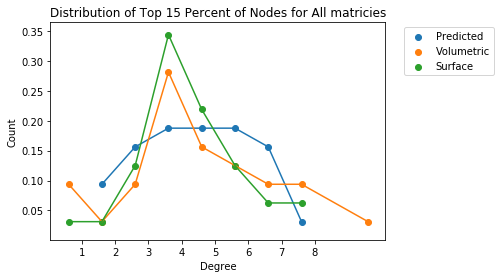

In [31]:
deg_dis_surface = generate_degree_distribution([np.copy(my_weights[:32,:32]), np.copy(weights[:32,:32]), np.copy(connections[:32, :32])], "All matricies", ["Predicted", "Volumetric", "Surface"], 15)


In [32]:
dictionary = dict()
degree, count = deg_dis[0][0], deg_dis[0][1]
for d, c in zip(degree, count):
    dictionary[d] = c
dictionary
len(values)

33

In [33]:
from statistics import median, mean

In [34]:
def show_node_scatter(x,y, xlabel:str, ylabel:str, title:str, cutoff = 0, coor = False):
    for i in range(len(x)):
        if i < 33 and x[i] > 1.5 * mean(x) and not coor: 
            plt.scatter(x[i], y[i], label = values[i])
            plt.annotate(keys[i], (x[i], y[i]))
        elif i >= 33 and x[i] > 1.5 * mean(x) and not coor:
            plt.scatter(x[i], y[i], label = values[65 - i])
            plt.annotate(keys[65 - i], (x[i], y[i]))
        elif i < 33 and x[i] < .5  and  coor: 
            plt.scatter(x[i], y[i], label = values[i])
            plt.annotate(keys[i], (x[i], y[i]))
        elif i >= 33 and x[i] < .5 and coor:
            plt.scatter(x[i], y[i], label = values[65 - i])
            plt.annotate(keys[65 - i], (x[i], y[i]))
        else:
            plt.scatter(x[i], y[i], c = "blue")
    plt.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


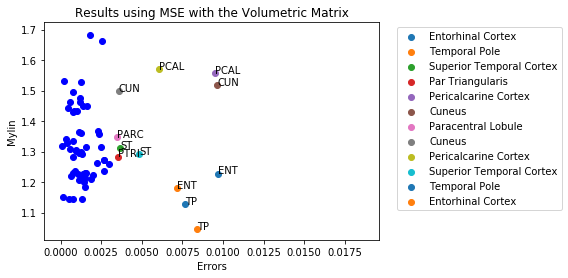

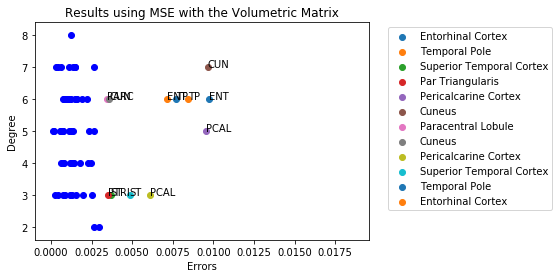

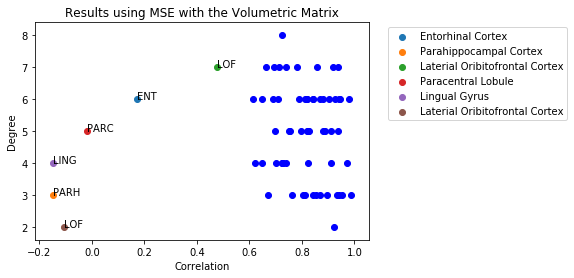

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [35]:
vol_error, correlations = generate_errors_and_correlation(weights, False)

title = "Results using MSE with the Volumetric Matrix"
show_node_scatter(vol_error, averages, "Errors", "Mylin", title)
show_node_scatter(vol_error, degree_array, "Errors", "Degree", title)
show_node_scatter(correlations, degree_array, "Correlation", "Degree",title, coor = True)
aver_er == vol_error

In [36]:
    np.savetxt("MSEerrorsVolumetric.txt", error)

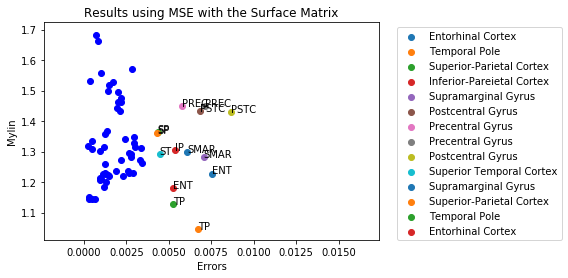

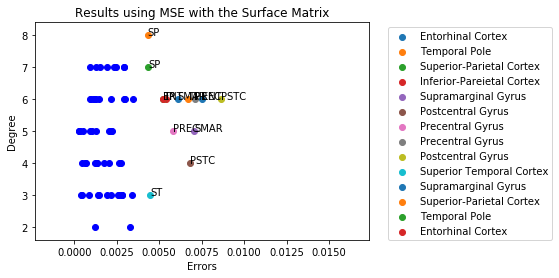

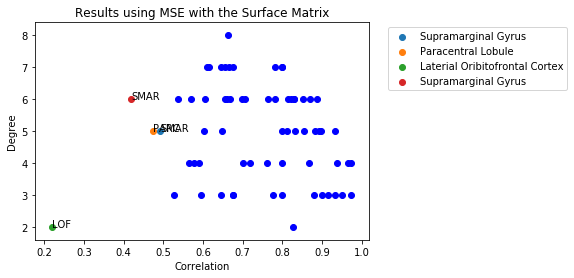

In [37]:
surf_error, correlations = generate_errors_and_correlation(connections, False)

title = "Results using MSE with the Surface Matrix"
show_node_scatter(surf_error, averages, "Errors", "Mylin", title)
show_node_scatter(surf_error, degree_array, "Errors", "Degree", title)
show_node_scatter(correlations, degree_array, "Correlation", "Degree",title, coor = True)

In [38]:
    np.savetxt("MSEerrorsSurface.txt", error1)

NameError: name 'error1' is not defined

In [ ]:
plt.plot(surf_error)

In [ ]:
np.savetxt("surferror.txt", surf_error)
np.savetxt("volerror.txt", vol_error)
